In [1]:
import os
import sys
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_dir = os.path.dirname(notebook_dir)

if project_dir not in sys.path:
    sys.path.append(project_dir)

import pandas as pd
import numpy as np

In [2]:
all_fighter_cluster = pd.read_csv(r"https://raw.githubusercontent.com/john-adeojo/ufc_styles/main/data/02_intermediate/all_fighter_clusters.csv")
fighter_data = pd.read_csv(r"https://github.com/john-adeojo/ufc_styles/blob/main/data/02_intermediate/fighter_data.csv?raw=true")
all_fighter_cluster = all_fighter_cluster.loc[all_fighter_cluster['cluster'] != -1]

In [3]:
analysis_data_base = fighter_data.merge(right=all_fighter_cluster[['cluster','specific_cluster', 'Fighter_dims', 'weight_class']], how='left', left_on=['Fighter_dims', 'weight_class'], right_on=['Fighter_dims', 'weight_class'])
analysis_data_base = analysis_data_base.dropna(subset=['cluster'])
analysis_data_opp = analysis_data_base.copy()
analysis_data_opp['opp_specific_cluster'] = analysis_data_opp['specific_cluster']
analysis_data = analysis_data_base.merge(right=analysis_data_opp[['weight_class', 'Fighter_dims', 'date', 'opp_specific_cluster']], how='inner', left_on=['weight_class', 'Opponent', 'date'], right_on=['weight_class', 'Fighter_dims', 'date'] )
analysis_data_opposing_styles = analysis_data.loc[analysis_data['opp_specific_cluster'] != analysis_data['specific_cluster']].copy()

In [4]:
analysis_data_opposing_styles = analysis_data_opposing_styles.loc[analysis_data_opposing_styles['corner'] == 'Red'].copy()
analysis_data_opposing_styles = analysis_data_opposing_styles.loc[analysis_data_opposing_styles['fighter_result'] != 'Loss by DQ'].copy()
analysis_data_opposing_styles = analysis_data_opposing_styles.loc[analysis_data_opposing_styles['fighter_result'] != 'Win by DQ'].copy()

In [5]:
import pandas as pd

# Assuming your DataFrame is named 'analysis_data_opposing_styles'
# and the columns to combine are 'specific_cluster' and 'opp_specific_cluster'

def create_style_matchup(row):
    # Combine the two columns and sort them alphabetically
    matchup = sorted([row['specific_cluster'], row['opp_specific_cluster']])
    
    # Join them with ' vs. ' and return the result
    return matchup[0] + ' vs. ' + matchup[1]

# Apply the custom function to each row and create the new 'style_matchup' column
analysis_data_opposing_styles['style_matchup'] = analysis_data_opposing_styles.apply(create_style_matchup, axis=1)

# Display the DataFrame
analysis_data_opposing_styles.sort_values(by='weight_class', inplace=True)


In [6]:
weight_class = list(analysis_data_opposing_styles['weight_class'].drop_duplicates())
weight_class

['Bantamweight',
 'Featherweight',
 'Heavyweight',
 'LightHeavyweight',
 'Lightweight',
 'Middleweight',
 'Welterweight']

In [7]:
from scripts.chisquareanalysis import ChiSquareAnalysis

# Assuming weight_class is a list of weight classes

results = {}  # Initialize an empty dictionary to store the results

for weights in weight_class:
    analysis = ChiSquareAnalysis(df=analysis_data_opposing_styles, weight_class=weights)
    result, significant_weight_class = analysis.run_chisquare_analysis('fighter_result')
    if not isinstance(result, str):
        results[significant_weight_class] = result  # Save the result in the dictionary with the key as the weight class
    

Bantamweight
Chi2 Stat: 244.45042522969314
P Value: 1.0943795416747109e-41
Degrees of Freedom: 18
Featherweight
Chi2 Stat: 406.3373017270569
P Value: 8.115557185945937e-45
Degrees of Freedom: 81
Heavyweight
Chi2 Stat: 749.7378583482009
P Value: 6.488876080819179e-146
Degrees of Freedom: 20
LightHeavyweight
Chi2 Stat: 570.0727926225678
P Value: 4.440800780200355e-92
Degrees of Freedom: 45
Lightweight
Chi2 Stat: 2548.586392046151
P Value: 0.0
Degrees of Freedom: 140
Middleweight
Chi2 Stat: 887.168883105777
P Value: 3.803177841194278e-160
Degrees of Freedom: 40
Welterweight
Chi2 Stat: 2262.132585205716
P Value: 0.0
Degrees of Freedom: 90


In [8]:
significant_weight_classes = list(results.keys())
significant_weight_classes

['Bantamweight',
 'Featherweight',
 'Heavyweight',
 'LightHeavyweight',
 'Lightweight',
 'Middleweight',
 'Welterweight']

In [9]:
fighter_result = list(analysis_data_opposing_styles['fighter_result'].drop_duplicates())

In [10]:
standard_residuals = {}  # Initialize an empty dictionary to store the results

for weights in significant_weight_classes:
    standard_residuals[weights] = results[weights]  # Save the result in the dictionary with the key as the weight class


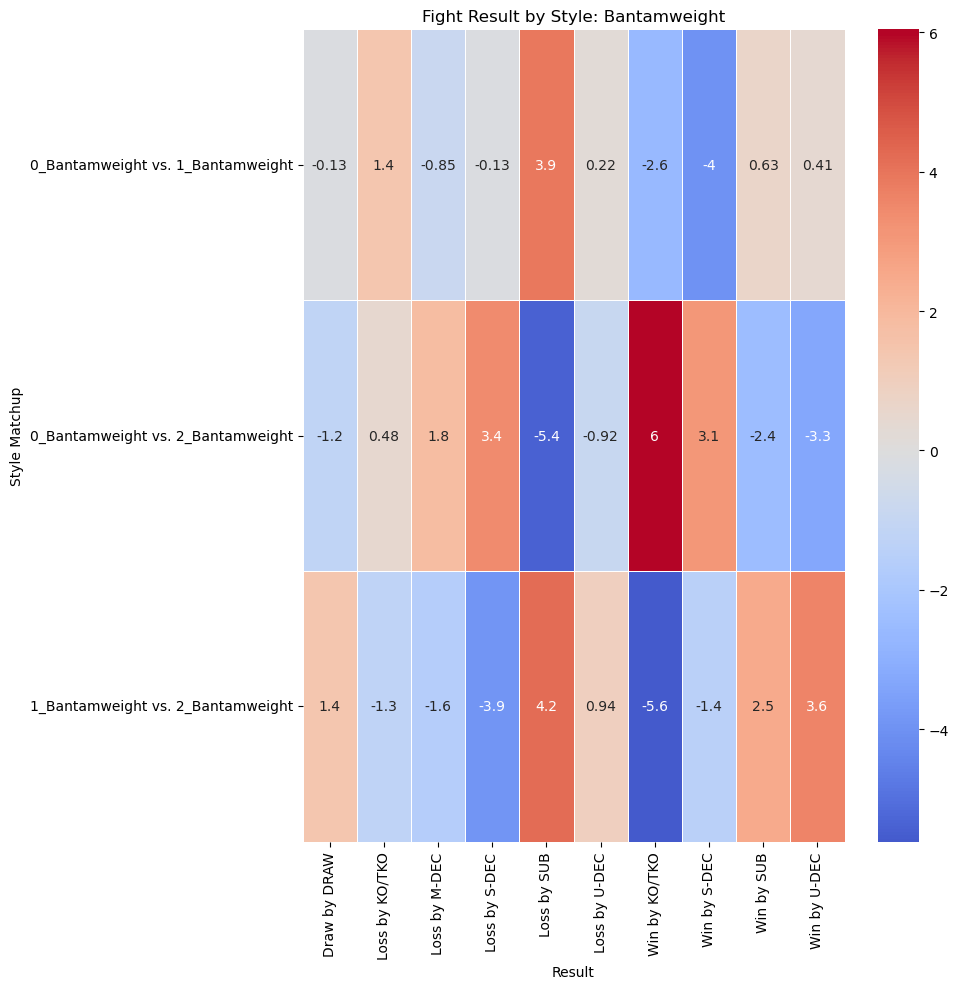

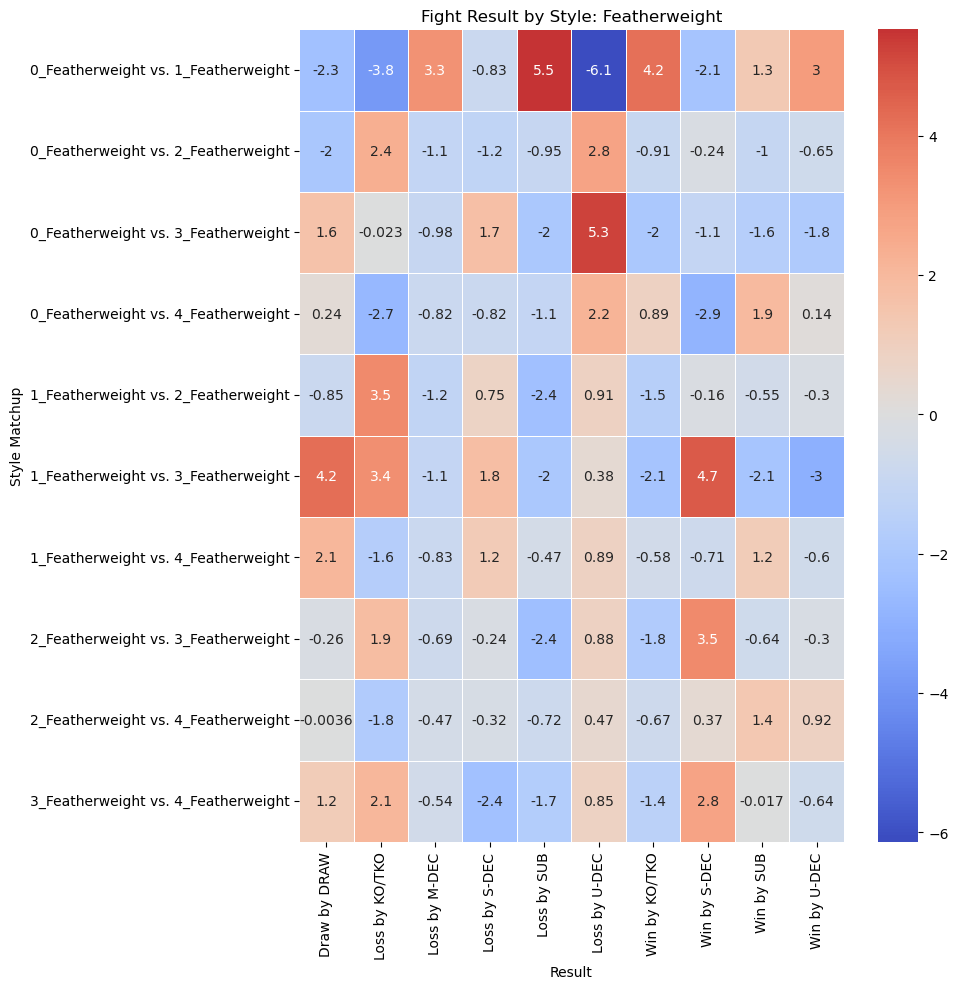

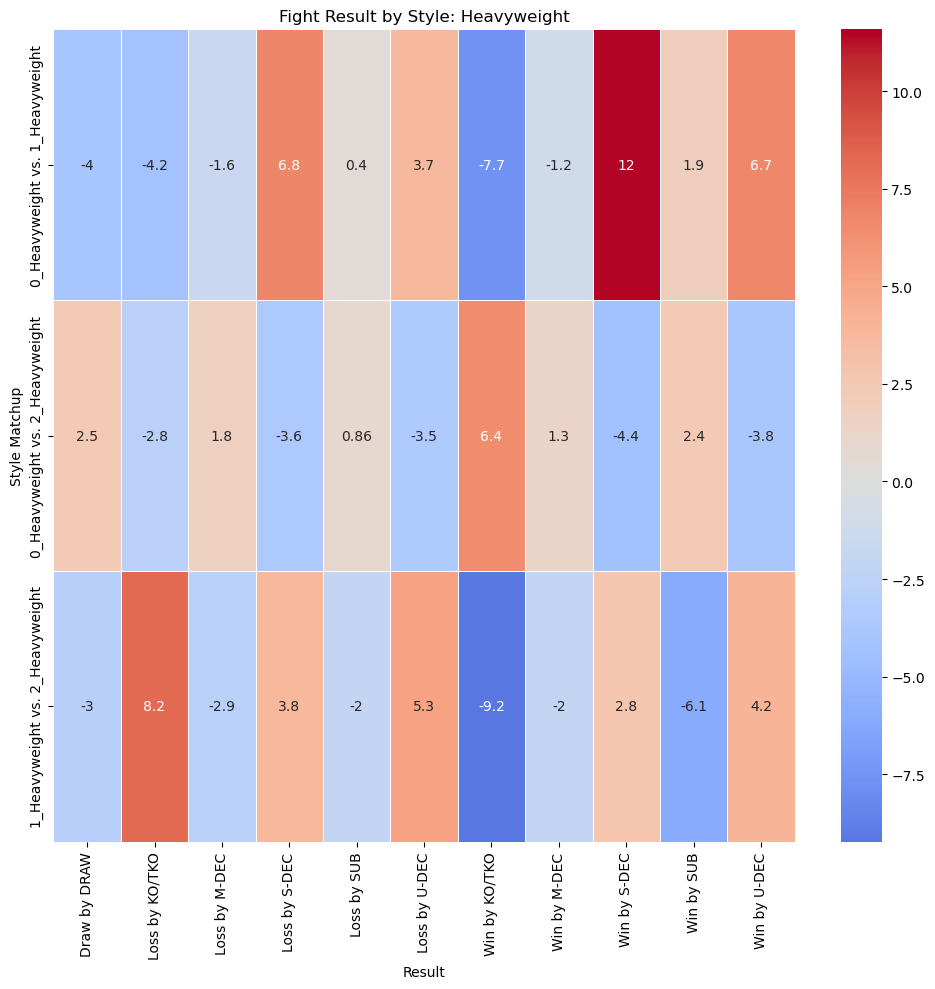

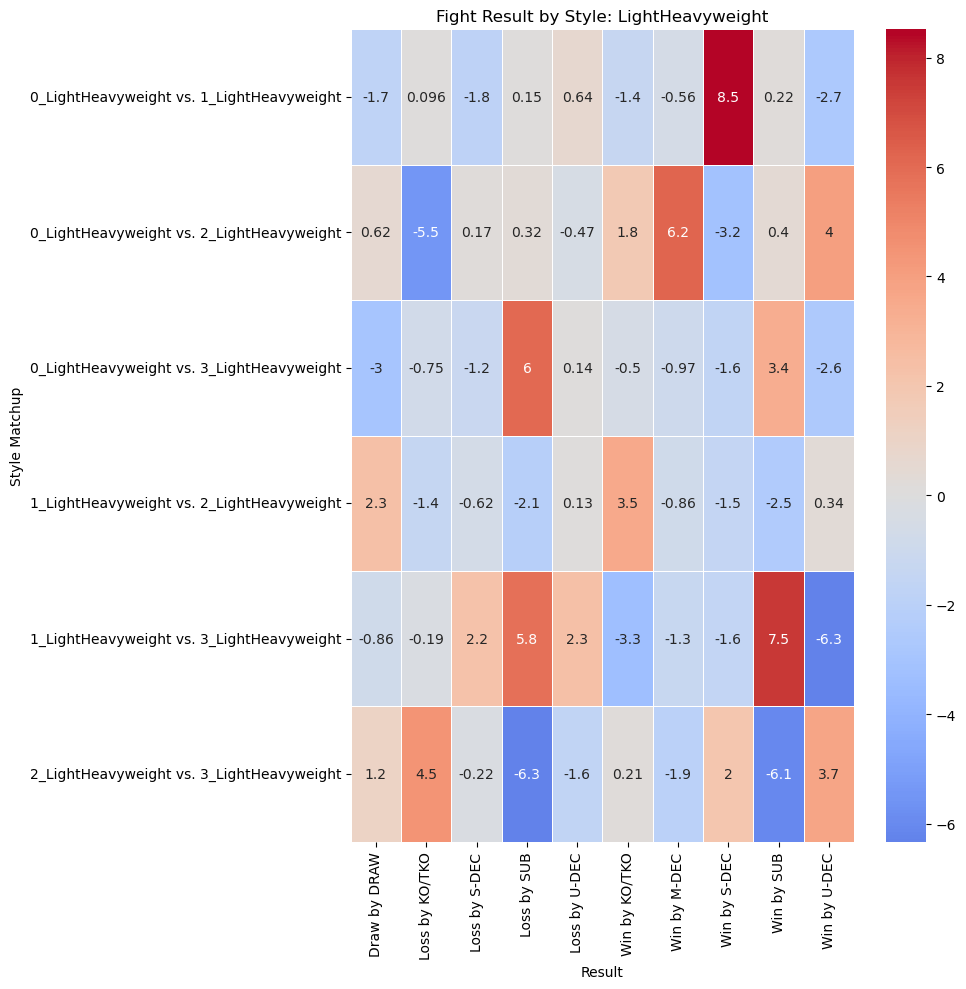

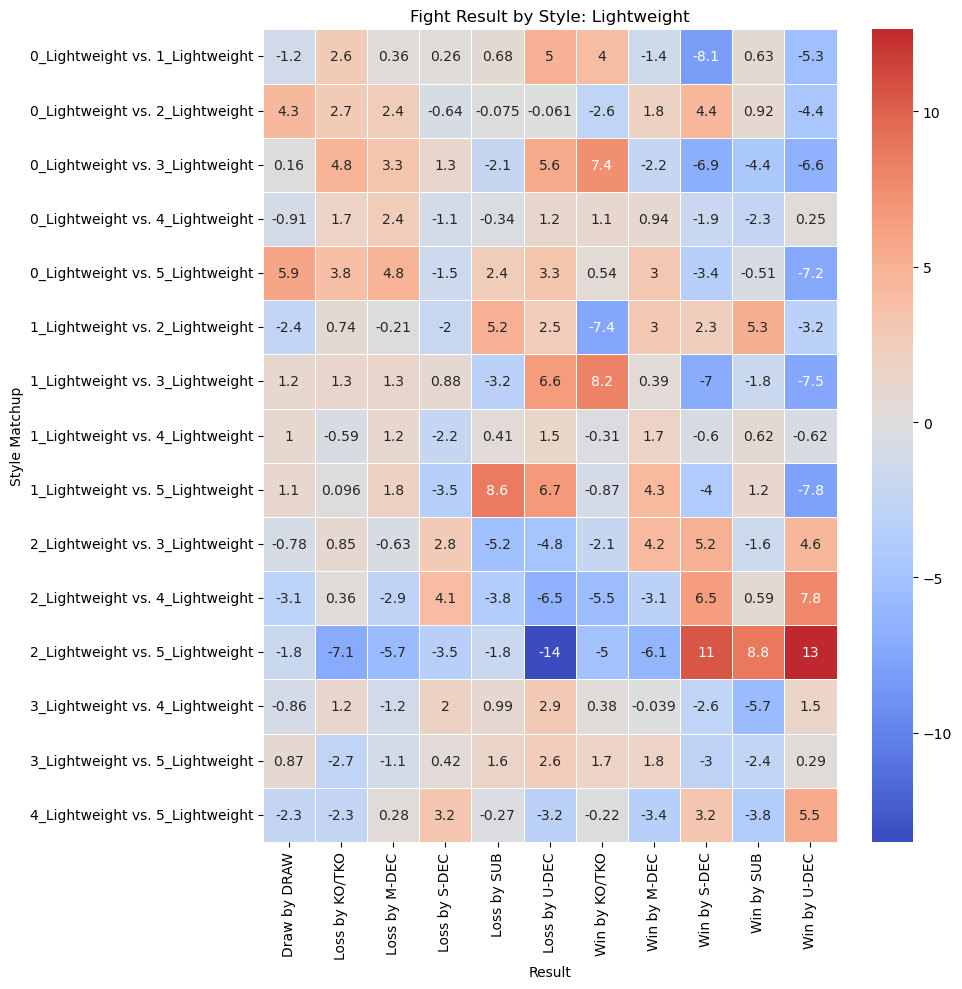

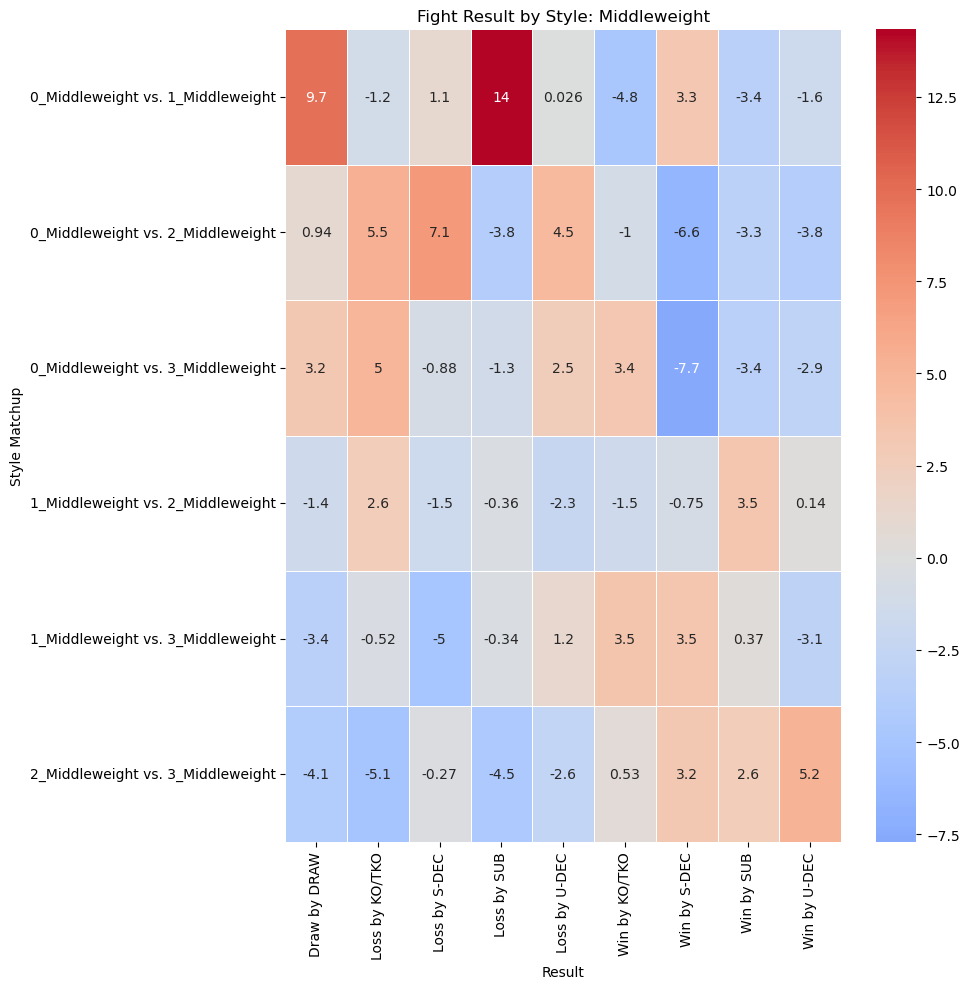

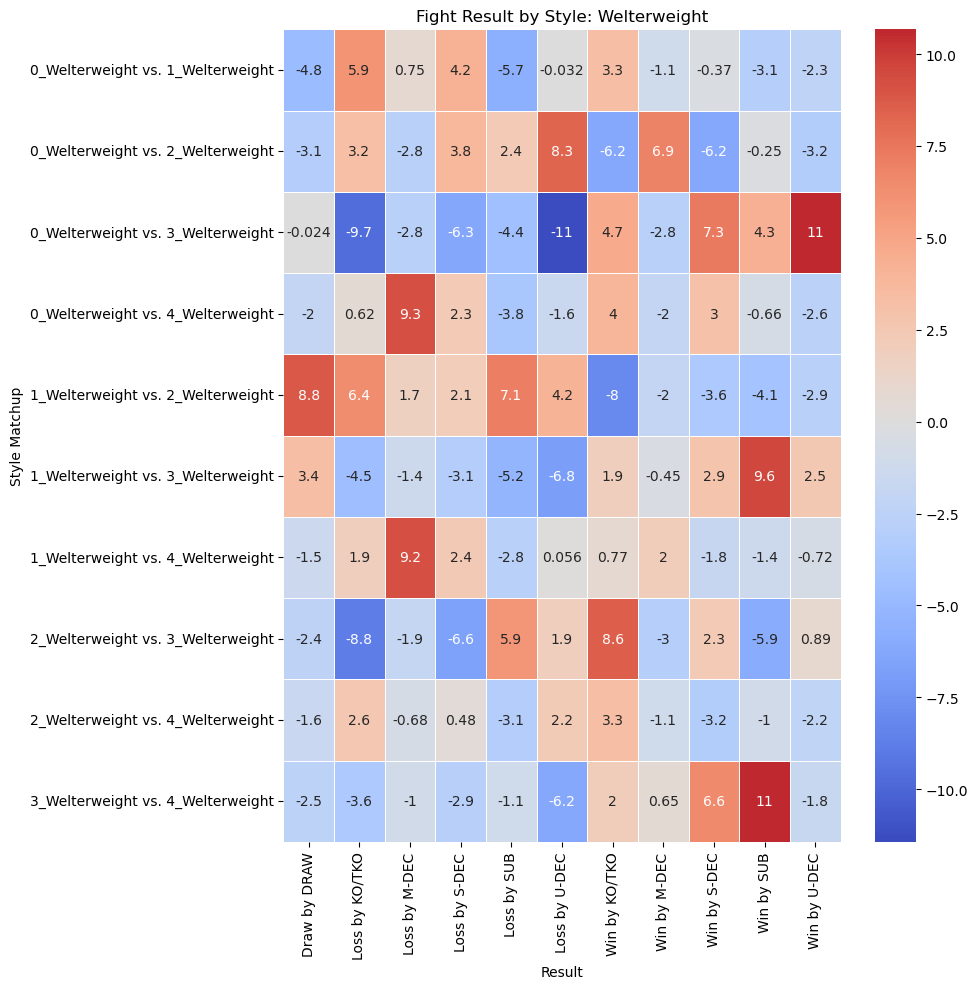

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap(standard_residuals, weight_class):
    col = standard_residuals.drop(columns=['style_matchup']).columns
    # Prepare the data for the heatmap
    heatmap_data = standard_residuals.set_index('style_matchup')[col]
    # Create the heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, linewidths=0.5, center=0)
    plt.title(f'Fight Result by Style: {weight_class}')
    plt.xlabel('Result')
    plt.ylabel('Style Matchup')
    plt.tight_layout()  # Add this line to adjust the layout
    plt.savefig(f"C:\\Users\\johna\\anaconda3\\envs\\ufc-env\\ufc_styles\\data\\03_reports\\residuals_{weight_class}.png")
    plt.show()

    
for weights in significant_weight_classes:
    heatmap(standard_residuals=standard_residuals[weights], weight_class=weights)


In [12]:
import requests
import json
# import style dims
url = 'https://github.com/john-adeojo/ufc_styles/raw/main/data/02_intermediate/style_dims_names.json'

# Fetch the JSON file content
response = requests.get(url)

# Check if the request was successful (HTTP status code 200)
if response.status_code == 200:
    try:
        # Load the content into a list
        style_dims_names = json.loads(response.text)
        print("Data loaded successfully:")
    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON: {e}")
else:
    print(f"Failed to fetch JSON file: {response.status_code}")

Data loaded successfully:


In [13]:
style_dims_names_2 = style_dims_names.copy()
style_dims_names_2.append('specific_cluster')
elements_to_remove = ['Stance_Open Stance', 'Stance_Orthodox', 'Stance_Sideways', 'Stance_Southpaw', 'Stance_Switch']
style_dims_names_2 = [elem for elem in style_dims_names_2 if elem not in elements_to_remove]

In [14]:
# def generate_radar_data(selected_clusters):
#     selected_clusters = selected_clusters
#     filtered_data = analysis_data_opposing_styles[analysis_data_opposing_styles['specific_cluster'].isin(selected_clusters)]
#     analytics_for_radar = filtered_data[style_dims_names_2].groupby(['specific_cluster']).mean()
#     analytics_for_radar.reset_index(inplace=True)
#     return analytics_for_radar

def generate_radar_data(selected_clusters):
    selected_clusters = selected_clusters
    filtered_data = analysis_data_opposing_styles[analysis_data_opposing_styles['specific_cluster'].isin(selected_clusters)]
    analytics_for_radar = filtered_data[style_dims_names_2].groupby(['specific_cluster']).mean()

    # Normalize columns except 'specific_cluster'
    for column in analytics_for_radar.columns:
        if column != 'specific_cluster':
            max_value = analytics_for_radar[column].max()
            min_value = analytics_for_radar[column].min()
            analytics_for_radar[column] = (analytics_for_radar[column] - min_value) / (max_value - min_value)

    analytics_for_radar.reset_index(inplace=True)
    return analytics_for_radar



radar_chart_data = {}
for weights in significant_weight_classes:
    selected_clusters = list(all_fighter_cluster.loc[all_fighter_cluster['weight_class'] == weights]['specific_cluster'].drop_duplicates())
    radar_chart_data[weights] = generate_radar_data(selected_clusters)
    

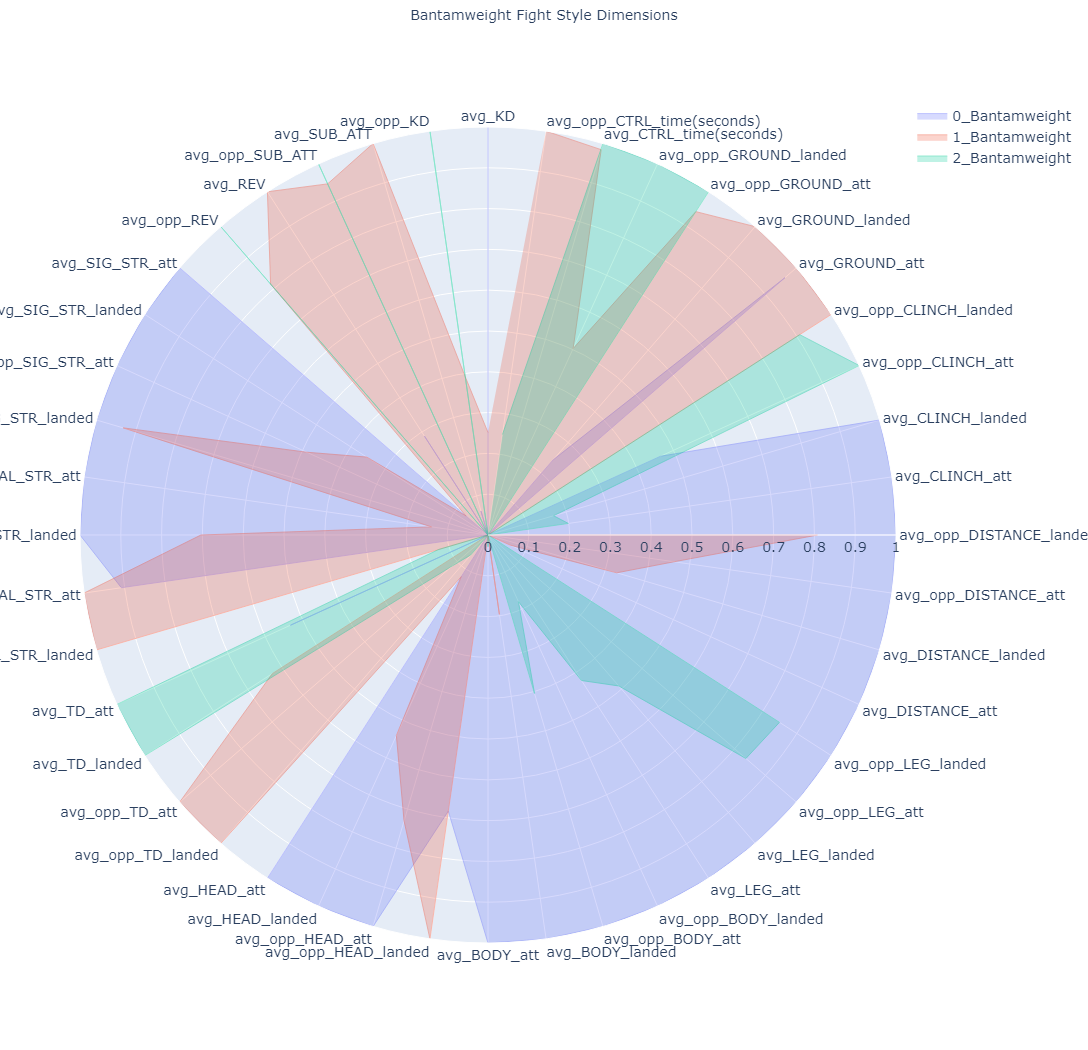

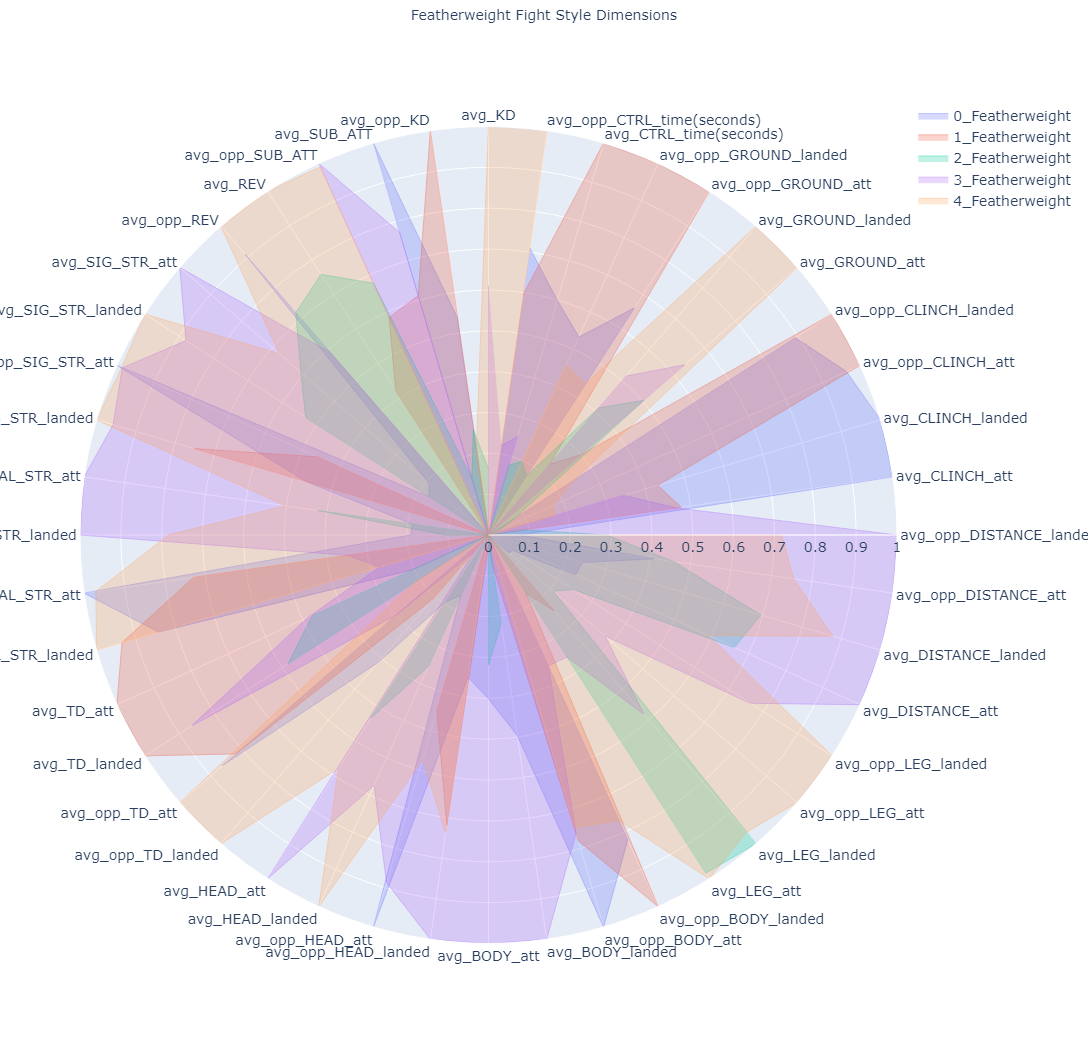

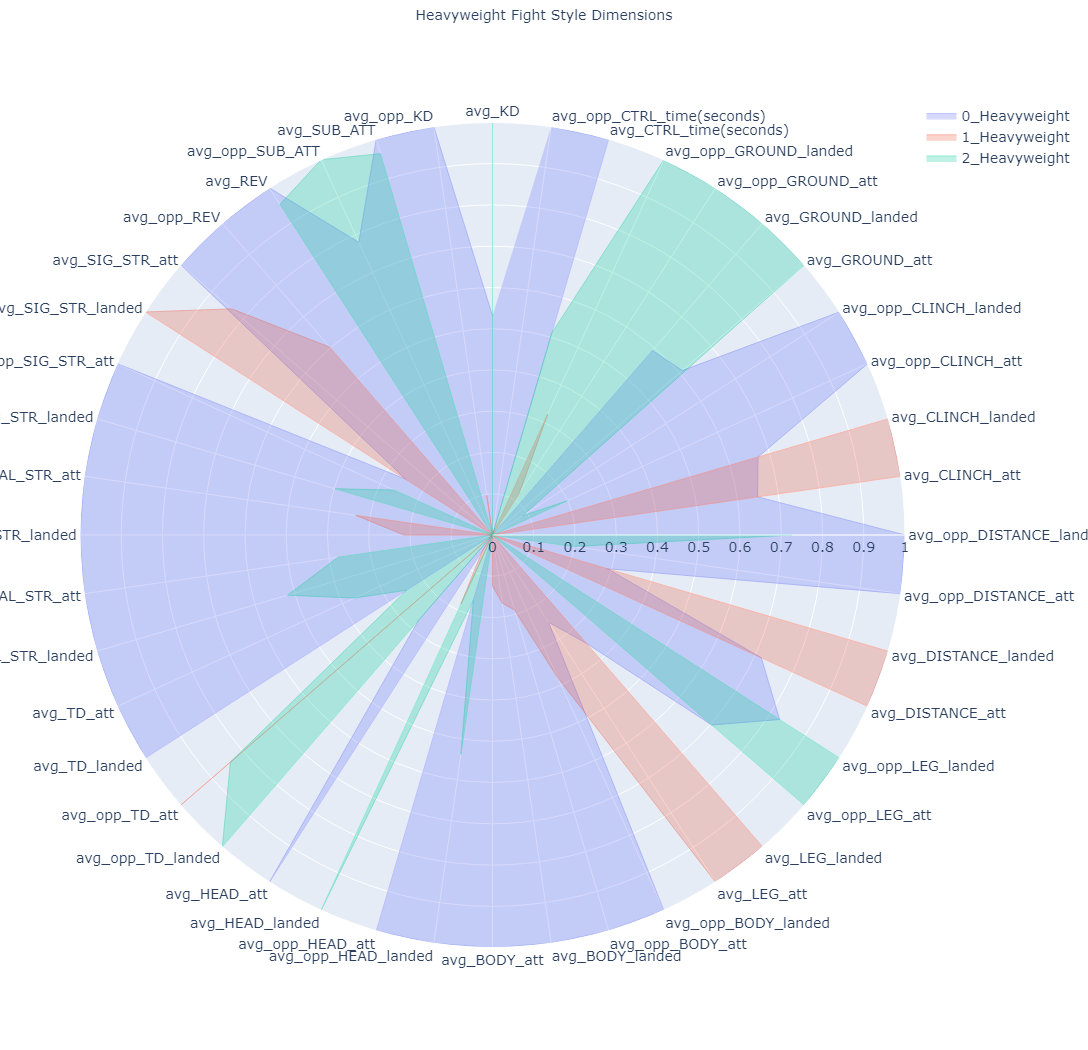

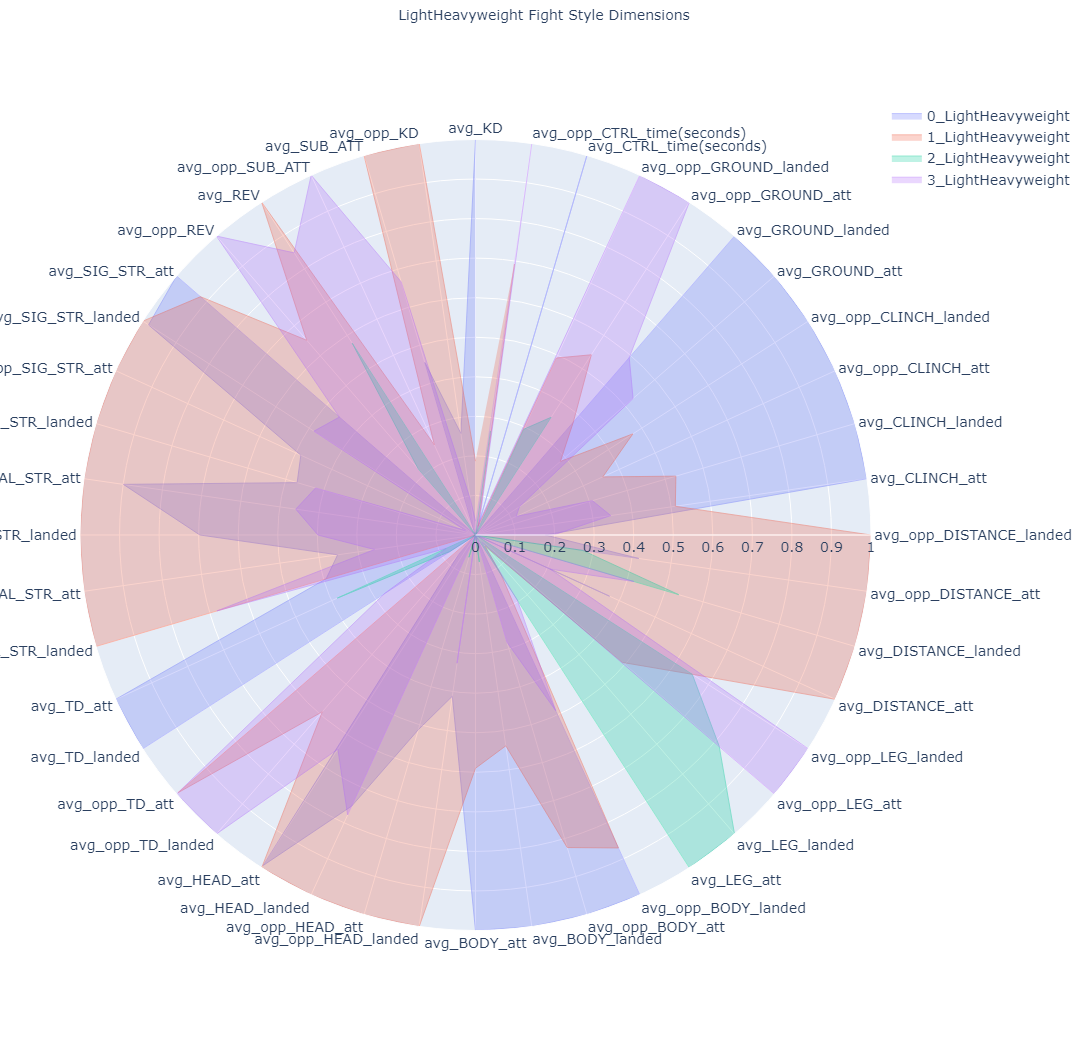

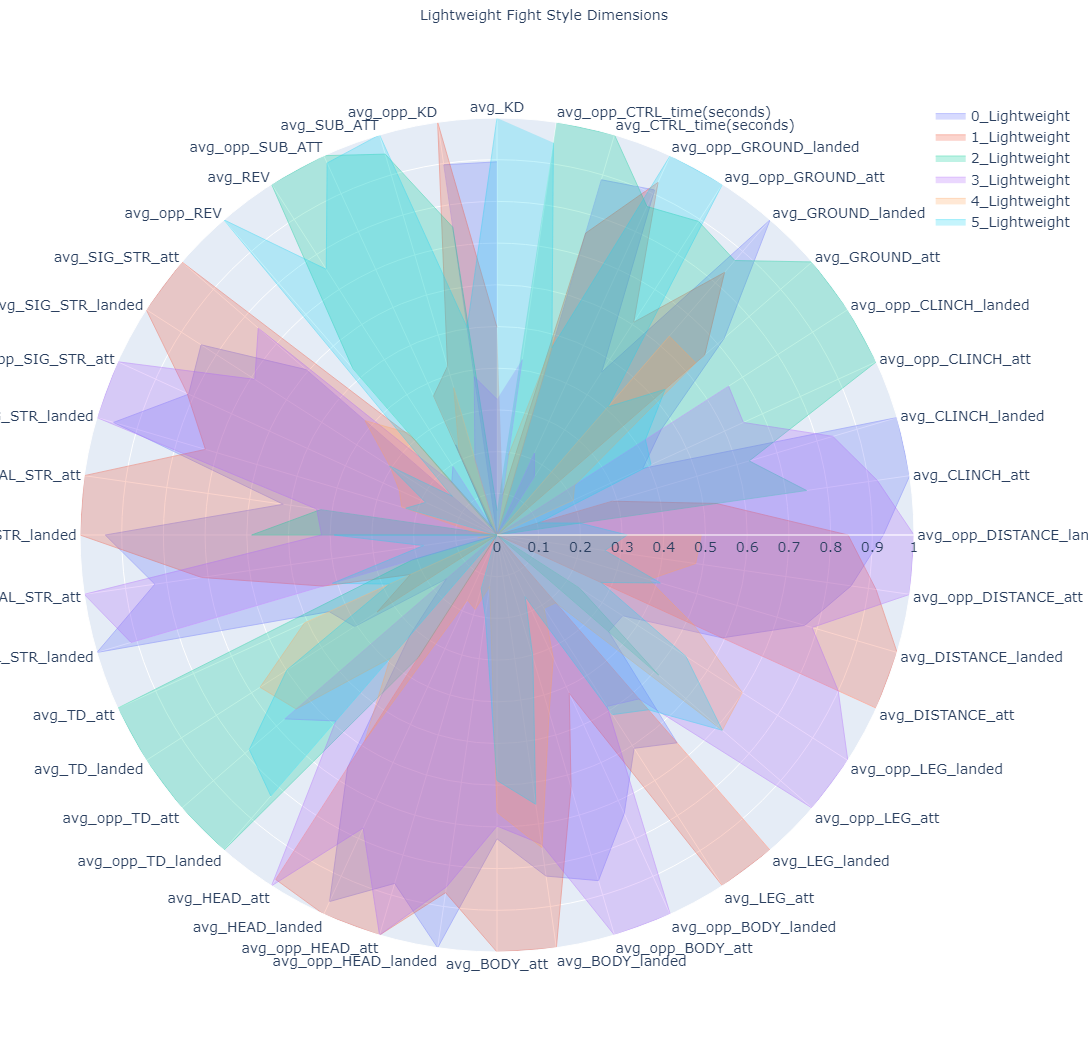

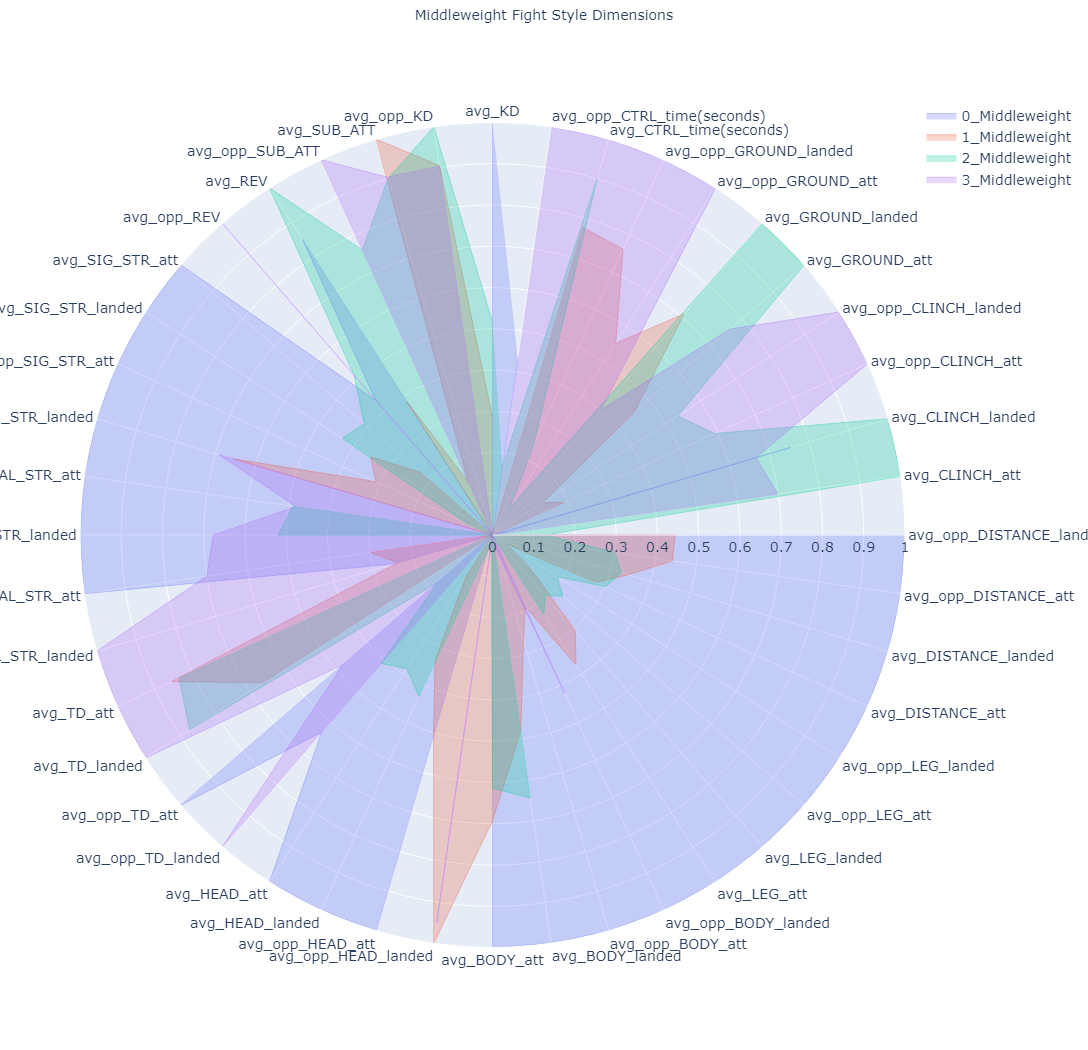

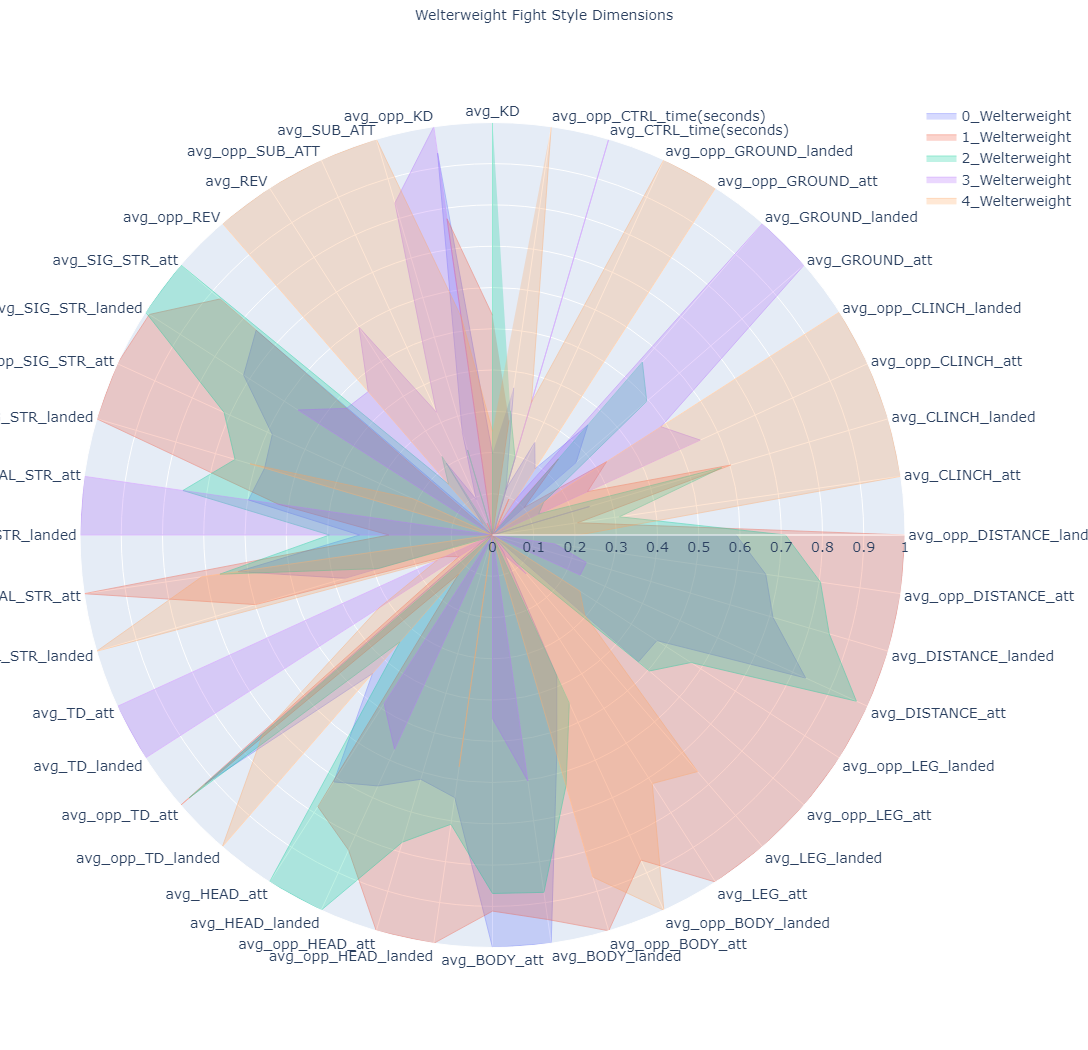

In [15]:
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd

def plot_fighters_radar_chart(data, weight_class, save_path):
    dimensions = data.drop(columns='specific_cluster').columns
    fig = go.Figure()

    for specific_cluster in data['specific_cluster'].unique():
        cluster_data = data[data['specific_cluster'] == specific_cluster]

        fig.add_trace(go.Scatterpolar(
            r=cluster_data[dimensions].values.tolist()[0],
            theta=dimensions,
            fill='toself',
            name=specific_cluster,
            opacity=0.5,
            line=dict(width=0.8)
        ))

    fig.update_layout(
        title=dict(
            text=f'{weight_class} Fight Style Dimensions',
            x=0.5,
            y=0.99,
            font=dict(size=14)
        ),

        
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, data[dimensions].values.astype(float).max()],
                tickfont=dict(size=14)  # Increase tick font size
            ),
            angularaxis=dict(
                rotation=90,
                direction="counterclockwise",
                tickfont=dict(size=14)  # Increase tick font size
            ),
        ),
        showlegend=True,
        width=1450,
        height=1050,
        legend=dict(font=dict(size=14))  # Increase legend font size
    )

    pio.write_image(fig, save_path)
    fig.show()

# Replace `significant_weight_classes` with the actual list of weight classes
for weights in significant_weight_classes:
    save_path = f"C:\\Users\\johna\\anaconda3\\envs\\ufc-env\\ufc_styles\\data\\03_reports\\radar_plots_{weights}.png"
    plot_fighters_radar_chart(data=radar_chart_data[weights], weight_class=weights, save_path=save_path)
